# **Объединение данных и их анализ**

**Задача**

В группе компаний Тинькофф есть команда edTech, создающая платформу для обучающих курсов.
У команды edTech возникает вопрос, а какие курсы сильнее всего влияют на рабочие показатели сотрудников в колл-центре.
Помогите составить рекомендации, какие обучающие курсы стоит проходить сотрудникам, а какие курсы стоит убрать с edTech платформы.
Решение может быть как рекомендательной моделью для каждого из сотрудников, так и основано на бизнес-правилах и статистическом анализе (например, выделить для каждого департамента полезные курсы).

**Потенциальное решение**

Предполагается, что решение будет выполнено на Python, будет итоговая презентация. Решение может содержать блоки: эксплораторный анализ, Causal Inference методы, рекомендательную модель.
Ограничений на подход к решению нет, но для определения важности курсов советуем использовать методы анализа причинности. Подробнее можно почитать о них [здесь,](https://koch-kir.medium.com/causal-inference-from-observational-data-%D0%B8%D0%BB%D0%B8-%D0%BA%D0%B0%D0%BA-%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%81%D1%82%D0%B8-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82-%D0%B1%D0%B5%D0%B7-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82%D0%B0-afb84f2579f2) а также возможна консультация со стороны организаторов.

# **Описание таблиц**

**employees**

Информация о сотрудниках колл-центра
Поля:
- employee_id - идентификатор сотрудника
- sex – пол
- region - идентификатор федерального округа
- age – возраст
- head_employee_id – идентификатор руководителя
- exp_days – опыт в днях
- edu_degree – уровень образования
- department_id – индентификатор департамента, в котором работает сотрудник
- work_online_flg – флаг работы на удалённом режиме

**communications**

Информация о рабочих показателях сотрудников. Рассматривались рабочие коммункации операторов колл-центра
Поля:
- communication_id – идентификатор коммуникации
- communication_dt – дата коммуникации
- employee_id - идентификатор сотрудника
- communication_score – оценка качества коммуникации
- util_flg – флаг того, что клиент воспользовался банковским продуктом в течение 2 недель

**courses_passing**

Статиситка прохождения обучающих курсов сотрудниками
- course_id – идентификатор курса
- employee_id - идентификатор сотрудника
- pass_frac – доля прохождения курса
- start_dt – дата начала прохождения
- last_activity_dt – последняя активность сотрудника в обучающем курсе
- end_dt – дата окончания обучения. Если обучение пройдено не полностью, то NaN
- educ_duration_days – длительность полного обучения в днях. Если обучение пройдено не полностью, то NaN

**courses_info**

Информация о курсах
- course_id – идентификатор курса
- course_nm – название курса

**course_employee_sms**

Сводная таблица с нотификациями сотрудникам с предложением пройти обучение. Нотификации рассылались случайным образом
Поля:
- employee_id - идентификатор сотрудника
- course_i – флаг наличия нотификации

План предобработки данных.

В скобках указаны свойства данных, выполнимость которых восстанавливается после проведения этапа:

a) Очистка данных (Data cleaning)

Обнаружение и удаление/замена
*   аномалий/выбросов, шумов   (**корректность**)
*   пропусков                  (**полнота**)
*   некорректных значений      (**непротиворечивость, ясность**)

b) Сокращение данных (Data Reduction)
*   Сэмплирование
*   Отбор признаков
*   Отбор объектов
*   Удаление дубликатов      (**безызбыточность**)

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from causalinference import CausalModel
from sklearn.utils import resample

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Установка опции для отображения нормальных чисел
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Объединие таблиц в один датасет

Загризим все датасеты

In [4]:
# Загрузим датасет
communications = pd.read_csv('../data/src/communications.csv', sep=';', dtype={'employee_id': 'category'})
courses_passing = pd.read_csv('../data/src/courses_passing.csv', sep=';',  dtype={'employee_id': 'category'})
employees = pd.read_csv('../data/src/employees.csv', sep=';', dtype={'employee_id': 'category', 'head_employee_id': 'category', 'sex': 'category'})
course_employee_sms = pd.read_csv('../data/src/course_employee_sms.csv', sep=';')
courses_info = pd.read_csv('../data/src/courses_info.csv', sep=';')

In [5]:
# Измененим типов данных некоторых столбцов
communications['communication_dt'] = pd.to_datetime(communications['communication_dt'])

Начнем с объединения таблиц `employees` и `communications`. В качестве ключа используем `employee_id` 

In [6]:
# Объединение данных
combined_data = pd.merge(employees, communications, on='employee_id', how='inner')

In [7]:
# Просмотр первых нескольких строк объединенной таблицы
combined_data.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1


In [8]:
# Описание новой таблицы
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5345246 entries, 0 to 5345245
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   employee_id          category      
 1   sex                  category      
 2   region               int64         
 3   age                  int64         
 4   head_employee_id     category      
 5   exp_days             int64         
 6   edu_degree           int64         
 7   department_id        int64         
 8   work_online_flg      int64         
 9   communication_id     int64         
 10  communication_dt     datetime64[ns]
 11  communication_score  int64         
 12  util_flg             int64         
dtypes: category(3), datetime64[ns](1), int64(9)
memory usage: 474.2 MB


Данные корректны. Далее добавим информацию из таблицы `courses_passing`

In [9]:
# Посмотрим первые 5 строк
courses_passing.head()

,course_id,employee_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,24,53ed35c7-4a2e-c275-b837-374f04396c03,1.00,2023-01-30 00:00:00,2023-02-05 00:00:00,2023-02-05 00:00:00,6.00
1,83,202cb962-ac59-075b-964b-07152d234b70,1.00,2023-08-29 00:00:00,2023-09-10 00:00:00,2023-09-10 00:00:00,12.00
2,4,05f971b5-ec19-6b8c-65b7-5d2ef8267331,1.00,2023-07-29 00:00:00,2023-08-09 00:00:00,2023-08-09 00:00:00,11.00
3,79,f4a331b7-a22d-1b23-7565-d8813a34d8ac,1.00,2023-05-30 00:00:00,2023-06-09 00:00:00,2023-06-09 00:00:00,10.00
4,6,aba3b6fd-5d18-6d28-e06f-f97135cade7f,1.00,2023-07-12 00:00:00,2023-07-22 00:00:00,2023-07-22 00:00:00,10.00


In [10]:
# Посмотрим информацию по датасету
courses_passing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   course_id           10950 non-null  int64   
 1   employee_id         10950 non-null  category
 2   pass_frac           10950 non-null  float64 
 3   start_dt            10950 non-null  object  
 4   last_activity_dt    10950 non-null  object  
 5   end_dt              8404 non-null   object  
 6   educ_duration_days  8404 non-null   float64 
dtypes: category(1), float64(2), int64(1), object(3)
memory usage: 613.1+ KB


Тут надо скорректировать типы данных:

In [11]:
# Преобразование pass_frac в булев тип
courses_passing['pass_frac'] = courses_passing['pass_frac'] > 0

In [12]:
# Сначала заменим NaN на 0, затем преобразуем в int
courses_passing['educ_duration_days'] = courses_passing['educ_duration_days'].fillna(0).astype(int)

In [13]:
# Преобразование строковых дат в datetime формат
courses_passing['start_dt'] = pd.to_datetime(courses_passing['start_dt'])
courses_passing['last_activity_dt'] = pd.to_datetime(courses_passing['last_activity_dt'])
courses_passing['end_dt'] = pd.to_datetime(courses_passing['end_dt'])

In [14]:
# Посмотрим информацию по датасету
courses_passing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   course_id           10950 non-null  int64         
 1   employee_id         10950 non-null  category      
 2   pass_frac           10950 non-null  bool          
 3   start_dt            10950 non-null  datetime64[ns]
 4   last_activity_dt    10950 non-null  datetime64[ns]
 5   end_dt              8404 non-null   datetime64[ns]
 6   educ_duration_days  10950 non-null  int32         
dtypes: bool(1), category(1), datetime64[ns](3), int32(1), int64(1)
memory usage: 495.4 KB


Теперь объединим таблицы `combined_data` и `courses_passing`

In [15]:
# Объединение combined_data с информацией о курсах
full_data = pd.merge(combined_data, courses_passing, on='employee_id', how='left')

In [17]:
# Рассмотрим первые 5 строк датасета
full_data.head(20)

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
5,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,501421070141925521,2023-09-26,0,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
6,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,909864723279817640,2023-10-29,74,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
7,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,761464608274903870,2023-01-08,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
8,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,443490016793310489,2023-03-24,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00
9,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,975412397240052933,2023-09-17,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11.00


In [18]:
# Рассмотрим информацию о датасете
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26020279 entries, 0 to 26020278
Data columns (total 19 columns):
 #   Column               Dtype         
---  ------               -----         
 0   employee_id          object        
 1   sex                  category      
 2   region               int64         
 3   age                  int64         
 4   head_employee_id     category      
 5   exp_days             int64         
 6   edu_degree           int64         
 7   department_id        int64         
 8   work_online_flg      int64         
 9   communication_id     int64         
 10  communication_dt     datetime64[ns]
 11  communication_score  int64         
 12  util_flg             int64         
 13  course_id            float64       
 14  pass_frac            object        
 15  start_dt             datetime64[ns]
 16  last_activity_dt     datetime64[ns]
 17  end_dt               datetime64[ns]
 18  educ_duration_days   float64       
dtypes: category(2), dat

In [18]:
# Посмотрим статистику по датасету
full_data.describe(include='all')

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
count,26020279,26020279,26020279.00,26020279.00,26020279,26020279.00,26020279.00,26020279.00,26020279.00,26020279.00,26020279,26020279.00,26020279.00,24624798.00,24624798,24624798,24624798,19129660,24624798.00
unique,2381,2,NaN,NaN,132,NaN,NaN,NaN,NaN,NaN,354,NaN,NaN,NaN,2,295,308,307,NaN
top,f016e59c-7ad8-b1d7-2903-bb1aa5720d53,F,NaN,NaN,4c56ff4c-e4aa-f957-3aa5-dff913df997a,NaN,NaN,NaN,NaN,NaN,2023-12-16 00:00:00,NaN,NaN,NaN,True,2023-01-11 00:00:00,2023-05-04 00:00:00,2023-05-24 00:00:00,NaN
freq,79825,13234381,NaN,NaN,583517,NaN,NaN,NaN,NaN,NaN,111040,NaN,NaN,NaN,24389614,311940,175611,146765,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 00:00:00,NaN,NaN,NaN,NaN,2023-01-11 00:00:00,2023-01-13 00:00:00,2023-01-14 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-20 00:00:00,NaN,NaN,NaN,NaN,2023-11-01 00:00:00,2023-11-16 00:00:00,2023-11-16 00:00:00,NaN
mean,NaN,NaN,2.74,31.82,NaN,393.29,1.62,1.45,0.56,500477168825372096.00,NaN,59.76,0.76,44.29,NaN,NaN,NaN,NaN,7.80
std,NaN,NaN,2.30,6.32,NaN,322.33,0.56,0.69,0.50,291784410029179648.00,NaN,37.17,0.43,26.90,NaN,NaN,NaN,NaN,5.00
min,NaN,NaN,0.00,19.00,NaN,0.00,0.00,0.00,0.00,1052382138.00,NaN,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00
25%,NaN,NaN,0.00,27.00,NaN,152.00,1.00,1.00,0.00,244119517333517120.00,NaN,32.00,1.00,20.00,NaN,NaN,NaN,NaN,5.00


## Обработка полученного датасета

Обработаем пропуски в датасете `full_data`

In [19]:
# Замена NaN в 'end_dt' и 'educ_duration_days'
full_data['end_dt'] = pd.to_datetime(full_data['end_dt'], errors='coerce')  # Преобразование в datetime, невалидные значения станут NaT
full_data['educ_duration_days'] = full_data['educ_duration_days'].fillna(0).astype(int)  # Замена NaN на 0 и преобразование в int

Теперь проверим нормализацию дат

In [20]:
# Убедимся, что все столбцы с датами имеют тип datetime
date_columns = ['communication_dt', 'start_dt', 'last_activity_dt', 'end_dt']
for col in date_columns:
    full_data[col] = pd.to_datetime(full_data[col], errors='coerce')  # Преобразование в datetime, невалидные значения станут NaT

In [21]:
# Проверка результатов
print(full_data[date_columns].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26020279 entries, 0 to 26020278
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   communication_dt  datetime64[ns]
 1   start_dt          datetime64[ns]
 2   last_activity_dt  datetime64[ns]
 3   end_dt            datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 992.6 MB
None


`Обработка пропущенных значений:` В `educ_duration_days` пропущенные значения заменяются на 0, что может быть интерпретировано как отсутствие завершения курса. В `end_dt` используется pd.to_datetime с errors='coerce', что преобразует некорректные или отсутствующие значения в NaT (Not a Time), что является аналогом NaN для временных данных.

`Нормализация дат:` Для каждого столбца с датами применяется pd.to_datetime для гарантии того, что все данные в этих столбцах будут иметь тип datetime64[ns], что обеспечивает унификацию формата и упрощает последующий анализ.

## Анализ полученного датасета

Сделаем анализ временных рядов и качество коммуникаций. Используя даты коммуникаций, можно анализировать, как изменяется качество коммуникаций сотрудников до и после прохождения определенных курсов.

Попробуем сделать следующим образом:
- Фильтрация данных: отфильтруем данные, чтобы оставить только те записи, где курс был завершен (по pass_frac и end_dt).
- Создание временного окна: определим временное окно до и после завершения курса (например, 30 дней до и после окончания курса).
- Группировка и агрегация данных: сравним среднее качество коммуникаций в этих временных окнах.
- Визуализация результатов: построим графики для визуального представления изменений.

In [22]:
# Фильтрация данных для анализа только успешно завершенных курсов
completed_courses = full_data[(full_data['pass_frac'] == 1.0) & (full_data['end_dt'].notna())]

# Определение временных окон для анализа
window_days = 30  # Количество дней для анализа до и после завершения курса

In [23]:
completed_courses

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26016472,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,6.00,True,2023-03-24,2023-04-02,2023-04-02,9
26016473,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,21.00,True,2023-07-18,2023-07-28,2023-07-28,10
26016474,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,57.00,True,2023-06-25,2023-07-02,2023-07-02,7
26016475,a64c94ba-af36-8e18-40a1-324e839230de,F,0,35,67c6a1e7-ce56-d3d6-fa74-8ab6d9af3fd7,1018,2,2,0,47280606271759106,2023-03-09,87,1,91.00,True,2023-06-15,2023-06-26,2023-06-26,11


In [24]:
# Добавляем временные окна к 'completed_courses'
completed_courses['start_window'] = completed_courses['end_dt'] - pd.Timedelta(days=window_days)
completed_courses['end_window'] = completed_courses['end_dt'] + pd.Timedelta(days=window_days)

In [25]:
# Сортировка данных в full_data по столбцу 'communication_dt'
full_data_sorted = full_data.sort_values(by='communication_dt')

# Сортировка данных в completed_courses по столбцу 'end_dt'
completed_courses_sorted = completed_courses.sort_values(by='end_dt')

# Произведем слияние датасетов
full_data_merged = pd.merge_asof(
    full_data_sorted,
    completed_courses_sorted[['employee_id', 'end_dt', 'start_window', 'end_window']],
    by='employee_id', 
    left_on='communication_dt', 
    right_on='end_dt',
    direction='nearest'
)

In [27]:
# Проверьте, содержит ли full_data_merged столбец 'end_dt'
full_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26020279 entries, 0 to 26020278
Data columns (total 22 columns):
 #   Column               Dtype         
---  ------               -----         
 0   employee_id          object        
 1   sex                  category      
 2   region               int64         
 3   age                  int64         
 4   head_employee_id     category      
 5   exp_days             int64         
 6   edu_degree           int64         
 7   department_id        int64         
 8   work_online_flg      int64         
 9   communication_id     int64         
 10  communication_dt     datetime64[ns]
 11  communication_score  int64         
 12  util_flg             int64         
 13  course_id            float64       
 14  pass_frac            object        
 15  start_dt             datetime64[ns]
 16  last_activity_dt     datetime64[ns]
 17  end_dt_x             datetime64[ns]
 18  educ_duration_days   int32         
 19  end_dt_y           

In [28]:
# Создание масок для определения коммуникаций до и после завершения курса
mask_before = (full_data_merged['communication_dt'] >= full_data_merged['start_window']) & (full_data_merged['communication_dt'] <= full_data_merged['end_dt_y'])
mask_after = (full_data_merged['communication_dt'] >= full_data_merged['end_dt_y']) & (full_data_merged['communication_dt'] <= full_data_merged['end_window'])

communications_before = full_data_merged.loc[mask_before]
communications_after = full_data_merged.loc[mask_after]

In [29]:
# Агрегация данных для анализа
avg_communication_scores_before = communications_before.groupby('employee_id')['communication_score'].mean()
avg_communication_scores_after = communications_after.groupby('employee_id')['communication_score'].mean()

In [30]:
# Вывод результатов
display(avg_communication_scores_before.head())
display(avg_communication_scores_after.head())

employee_id
00411460-f7c9-2d21-24a6-7ea0f4cb5f85   57.17
006f52e9-102a-8d3b-e2fe-5614f42ba989   62.40
00a03ec6-533c-a7f5-c644-d198d815329c   62.58
00ac8ed3-b432-7bdd-4ebb-ebcb2ba10a00   57.15
00e26af6-ac3b-1c1c-49d7-c3d79c60d000   57.17
Name: communication_score, dtype: float64

employee_id
00411460-f7c9-2d21-24a6-7ea0f4cb5f85   58.81
006f52e9-102a-8d3b-e2fe-5614f42ba989   61.24
00a03ec6-533c-a7f5-c644-d198d815329c   62.35
00ac8ed3-b432-7bdd-4ebb-ebcb2ba10a00   57.85
00e26af6-ac3b-1c1c-49d7-c3d79c60d000   55.72
Name: communication_score, dtype: float64

In [31]:
# Слияние результатов для сравнения
comparison = pd.DataFrame({
    'Before': avg_communication_scores_before,
    'After': avg_communication_scores_after
}).dropna()

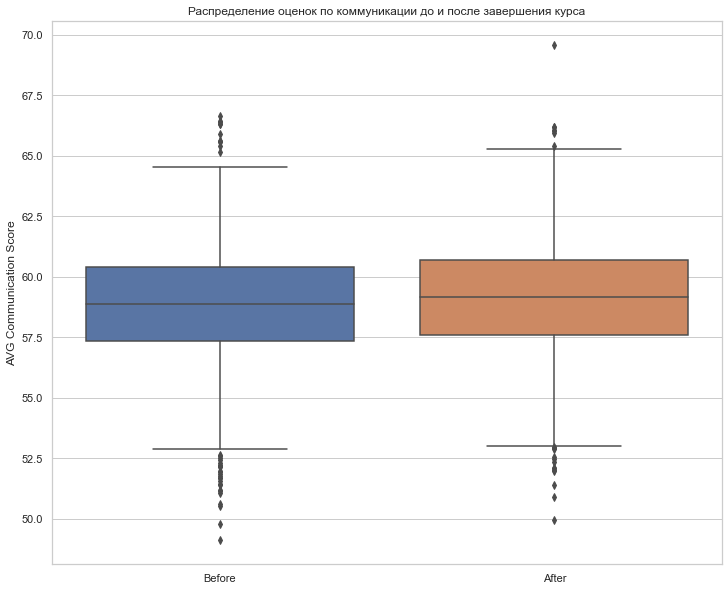

In [33]:
# Проверим Seaborn
sns.set_theme(style="whitegrid")

# Подготовка данных для боксплотов
data_for_boxplot = pd.melt(comparison.reset_index(), id_vars=['employee_id'], var_name='Period', value_name='Score')

# Построение боксплотов
plt.figure(figsize=(12, 10))
sns.boxplot(x='Period', y='Score', data=data_for_boxplot)
plt.title('Распределение оценок по коммуникации до и после завершения курса')
plt.xlabel('')
plt.ylabel('AVG Communication Score')
plt.show()

По графику можно увидеть, что:
- Центральная тенденция: медианное значение оценок коммуникаций после прохождения курса кажется несколько выше, чем до прохождения курса. Это может указывать на то, что в среднем курсы оказали положительное влияние на оценки коммуникаций.
- Разброс: межквартильный размах после прохождения курса кажется больше, чем до. Это может означать, что хотя средние оценки увеличились, разнообразие оценок коммуникаций также увеличилось. Иными словами, у некоторых сотрудников результаты улучшились более значительно, чем у других.
- Выбросы: на графиках до и после курса присутствуют выбросы. Это могут быть аномально низкие или высокие оценки по сравнению с основной массой данных. После курса количество выбросов, кажется, увеличилось, что может указывать на большее разнообразие в результатах коммуникаций сотрудников.
- Симметрия: распределение оценок до прохождения курса выглядит более симметричным, в то время как после курса боксплот выглядит более смещенным вверх, что может говорить о положительном смещении результатов.

Теперь попробуем сделать статистический и причинно-следственный анализ - использование методов Causal Inference для определения влияния прохождения курсов на рабочие показатели. Попробуем использовать пропенсити скоринг, чтобы оценить влияние прохождения курсов на оценки коммуникаций сотрудников. Пропенсити скоринг пытается сбалансировать наблюдаемые ковариаты между обработанными и контрольными группами, чтобы приблизить рандомизированное контролируемое исследование.

In [39]:
full_data.head()

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,communication_id,communication_dt,communication_score,util_flg,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days,course_taken
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,14921849450201131,2023-05-30,64,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11,True
1,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,209971243798358860,2023-02-17,66,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11,True
2,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,503301393365124883,2023-11-13,74,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11,True
3,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,663626121892584935,2023-07-04,0,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11,True
4,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1,692074302944109718,2023-11-28,100,1,48.00,True,2023-08-19,2023-08-30,2023-08-30,11,True


In [37]:
# Преобразование 'True'/'False' в 1/0
full_data['course_taken'] = full_data['pass_frac'].replace({'True': 1, 'False': 0})

In [40]:
mode_value = full_data['course_taken'].mode()[0]
full_data['course_taken'].fillna(mode_value, inplace=True)

In [41]:
# Создание временных признаков
full_data['time_since_last_activity'] = (full_data['communication_dt'] - full_data['last_activity_dt']).dt.days
full_data['time_since_end'] = (full_data['communication_dt'] - full_data['end_dt']).dt.days.fillna(0)

In [42]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26020279 entries, 0 to 26020278
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   employee_id               object        
 1   sex                       category      
 2   region                    int64         
 3   age                       int64         
 4   head_employee_id          category      
 5   exp_days                  int64         
 6   edu_degree                int64         
 7   department_id             int64         
 8   work_online_flg           int64         
 9   communication_id          int64         
 10  communication_dt          datetime64[ns]
 11  communication_score       int64         
 12  util_flg                  int64         
 13  course_id                 float64       
 14  pass_frac                 object        
 15  start_dt                  datetime64[ns]
 16  last_activity_dt          datetime64[ns]
 17  end_dt

In [43]:
# Дополнение списка признаков
feature_cols = ['sex', 'region', 'age', 'exp_days', 'edu_degree', 'department_id', 'work_online_flg', 'educ_duration_days', 'time_since_last_activity', 'time_since_end']
# Преобразование столбцов к типу 'category', если они уже не таковы
for col in ['sex', 'region', 'edu_degree', 'department_id', 'work_online_flg']:
    full_data[col] = full_data[col].astype('category')
# Индексы категориальных переменных должны быть указаны как список имен столбцов
categorical_features_indices = ['sex', 'region', 'edu_degree', 'department_id', 'work_online_flg']

In [44]:
# Сортировка данных по дате начала курса
full_data_sorted = full_data.sort_values(by=['communication_dt', 'start_dt'])

# Определение точки разделения (например, 80% данных для обучения)
split_index = int(len(full_data_sorted) * 0.8)

# Разделение данных на обучающую и тестовую выборки
X_train = full_data_sorted[feature_cols].iloc[:split_index]
y_train = full_data_sorted['course_taken'].iloc[:split_index]
X_test = full_data_sorted[feature_cols].iloc[split_index:]
y_test = full_data_sorted['course_taken'].iloc[split_index:]

In [45]:
# Обучение CatBoost модели на GPU
model = CatBoostClassifier(
    cat_features=categorical_features_indices,
    task_type='GPU',
    verbose=False, 
    eval_metric='F1',
    iterations=100,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3
)

In [46]:
# Обучим модель
model.fit(X_train, y_train)

In [47]:
# Получение пропенсити скоров
propensity_scores = model.predict_proba(X_test)[:, 1]

In [48]:
# Убедимся, что propensity_scores является pandas.Series и имеет тот же индекс, что и X_test
propensity_scores_series = pd.Series(propensity_scores, index=X_test.index)

In [49]:
# Зададим объем данных для анализа
small_X_test = resample(X_test, replace=False, n_samples=50000, random_state=42)
small_y_test = y_test.loc[small_X_test.index]
small_propensity_scores = propensity_scores_series.loc[small_X_test.index]

In [51]:
# Оценка каузального эффекта на уменьшенном наборе данных
causal = CausalModel(Y=full_data.loc[small_X_test.index, 'communication_score'].values,
                     D=small_y_test.values,
                     X=small_propensity_scores.values)
causal.est_via_matching(bias_adj=True)

# Вывод результатов
print("Causal Estimates:", causal.estimates)

Causal Estimates: 
Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     44.999     23.059      1.951      0.051     -0.196     90.195
           ATC      4.307      3.947      1.091      0.275     -3.430     12.044
           ATT     45.343     23.252      1.950      0.051     -0.231     90.917



Выводы:
- **ATE (Average Treatment Effect):**

    - Оценка (Est.): 44.999
    - Стандартная ошибка (S.e.): 23.059
    - Z-статистика: 1.951
    - P-значение: 0.051
    - 95% Доверительный интервал: от -0.196 до 90.195

    ATE оценивает среднее влияние прохождения курсов на всех сотрудников. Значение оценки в 44.999 указывает на положительный эффект обучения, предполагая, что прохождение курсов в среднем улучшает рабочие показатели на 44.999 единицы. Однако, P-значение (0.051) и доверительный интервал, включающий ноль, показывают, что данный результат находится на грани статистической значимости и не дает уверенности в том, что обучение имеет значимый положительный эффект.

- **ATC (Average Treatment Effect on Controls):**

    - Оценка: 4.307
    - Стандартная ошибка: 3.947
    - Z-статистика: 1.091
    - P-значение: 0.275
    - 95% Доверительный интервал: от -3.430 до 12.044

    ATC показывает эффект обучения на тех, кто не прошел курсы. Маленькая положительная оценка 4.307 и не значимое P-значение (0.275) говорят о том, что не проходившие курсы сотрудники не показывают значимого изменения в рабочих показателях из-за непрохождения курсов.

- **ATT (Average Treatment Effect on the Treated):**

    - Оценка: 45.343
    - Стандартная ошибка: 23.252
    - Z-статистика: 1.950
    - P-значение: 0.051
    - 95% Доверительный интервал: от -0.231 до 90.917

    ATT оценивает влияние курсов на тех, кто их прошел. Похоже на ATE, значение в 45.343 также указывает на положительный эффект обучения, но также находится на грани статистической значимости с P-значением 0.051 и доверительным интервалом, включающим ноль.